In [2]:
import emcee
import corner
from LC_GenMock import *
import LC_model
from multiprocessing import Pool
%matplotlib inline

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#Set Up paramters
spot_stength = 2000 #ppm
spot_width = 0.05 #days
transit_window = 10 #hours
spot_location = 0#5/24*0.5 #days
theta_0 = [140.5,0.0576,1.571, 224.22]
ld_coef = [0.47,0.19]
z0 =120
p = 0.06
inc = 1.577
period = 233.6
gamma1 = 0.3
gamma2 = 0.1
theta = np.array([z0,p,inc,period,gamma1,gamma2])


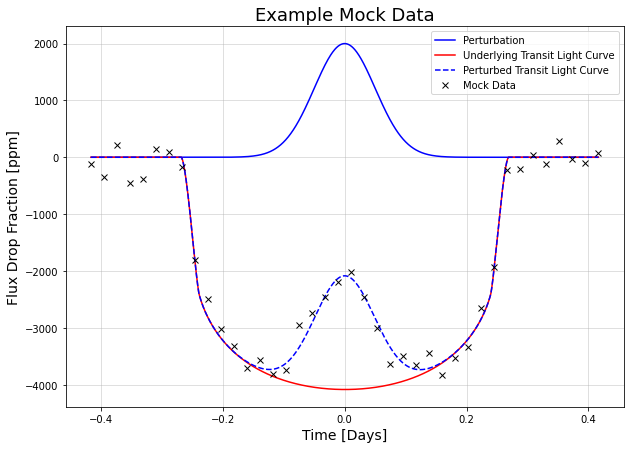

In [6]:
#generate mock data
results = generate_mock_data(theta_0,ld_coef,transit_window,
                             spot_location,spot_stength,spot_width)
x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = results
fig = plot_mock_data( *results)

Best estimate LS:
 [1.06792405e+02 5.64987229e-02 1.57797751e+00 2.56974226e+02
 1.08728860e-21 6.34769881e-26]
Error on LS estimate:
 [2.07976391e+05 8.22897985e-03 1.39835853e+01 5.00584528e+05
 4.05887690e+00 4.03035583e+00]
[140.5, 0.0576, 1.571, 224.22] [1.06792405e+02 5.64987229e-02 1.57797751e+00 2.56974226e+02
 1.08728860e-21 6.34769881e-26]


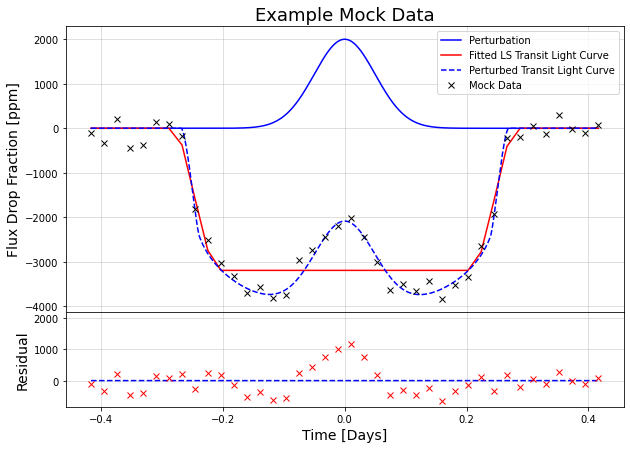

In [7]:
#Fit Mock Data
time = x_mock
flux = y_mock*1e-6+1

fit = LC_model.transit_fit(theta[:-2],theta[-2:],method="quad_ld")
popt,pocv = fit.ls_fit(time,flux)

print("Best estimate LS:\n", popt)
popt_err = np.diag(pocv)**0.5
print("Error on LS estimate:\n", popt_err)
fit = LC_model.transit_fit(popt[:-2],popt[-2:],method="quad_ld")
y_ls = fit.transit_model(time)

fig = plot_mock_data( *[x_mock, y_mock, time, 
                                    (y_ls-1)*1e6, anomaly, y_anomaly],
                         label = 'Fitted LS Transit Light Curve',res=True)

#biases = theta_0-popt
print(theta_0,popt)

In [9]:
trials = 1000
params = np.zeros((trials,theta.size))

def run_one_trial(index):
    
    global theta,theta_0,transit_window, spot_location ,spot_stength,spot_width

    np.random.seed(index)
    r = generate_mock_data(theta_0,ld_coef,transit_window,
                             spot_location,spot_stength,spot_width)
    
    x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = r
    

    time = x_mock
    flux = y_mock*1e-6+1

    fit = LC_model.transit_fit(theta[:-2],theta[-2:],method="quad_ld")
    popt2,pocv2 = fit.ls_fit(time,flux)
    print(index)
    return popt2

with Pool(8) as pl:
    params = pl.map(run_one_trial, [j for j in range(trials)])
params = np.vstack(params)
np.save("params_withpert",params)

96
0
192
128
160
224
64
97
129
1
161
65
32
193
2
130
98
66
162
3
131
67
163
4
68
164
225
194
5
69
165
195
6
226
33
166
7
196
99
227
70
34
167
197
100
8
71
228
132
198
9
101
168
229
72
133
169
10
199
230
102
73
134
11
103
200
170
74
231
12
135
201
104
171
75
13
35
232
136
105
172
202
36
233
137
76
14
106
203
37
234
77
173
15
204
235
78
174
205
107
79
175
108
206
16
80
38
176
17
109
81
207
39
208
82
18
110
40
19
209
138
41
111
210
236
20
139
83
42
112
21
84
140
237
113
43
141
85
22
238
44
114
86
142
23
45
115
239
87
46
143
177
116
211
240
24
88
144
212
117
47
178
241
89
118
145
213
242
48
179
90
214
146
243
49
180
215
244
50
181
245
51
119
182
216
91
120
52
183
217
25
92
121
53
218
93
26
54
94
246
122
27
123
55
124
28
247
56
219
29
125
248
147
95
148
57
256
30
149
58
126
220
150
31
59
127
257
249
151
221
60
320
258
222
250
61
321
152
223
62
259
251
153
352
184
63
252
260
353
384
185
253
288
154
261
322
354
254
186
289
155
385
262
355
323
255
290
187
386
263
356
324
416
156
291
188
387
26

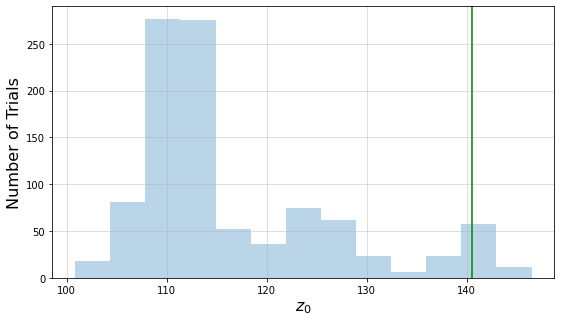

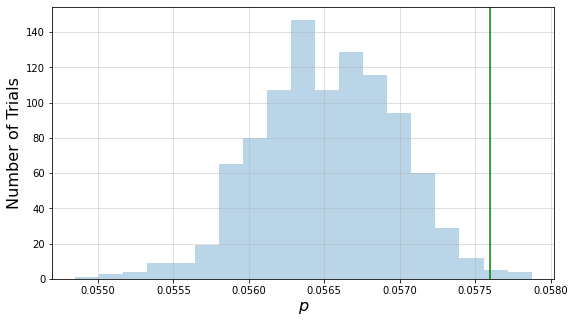

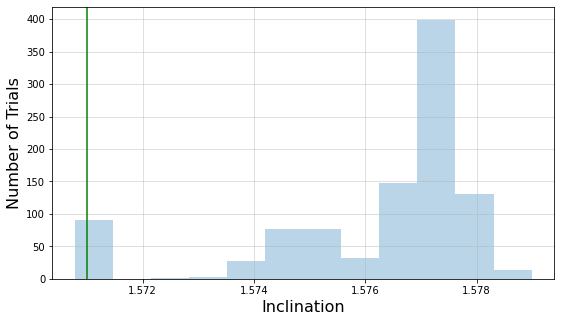

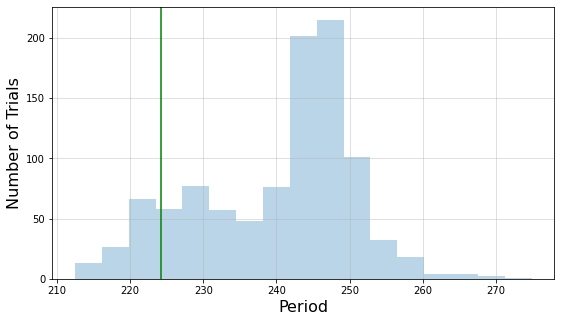

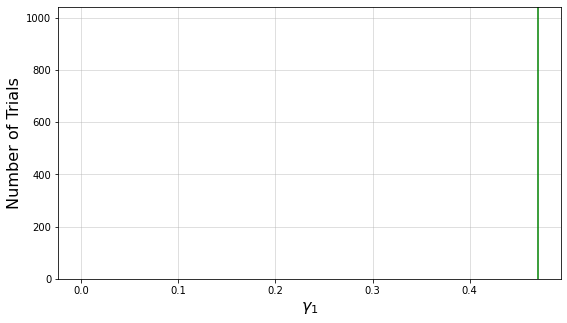

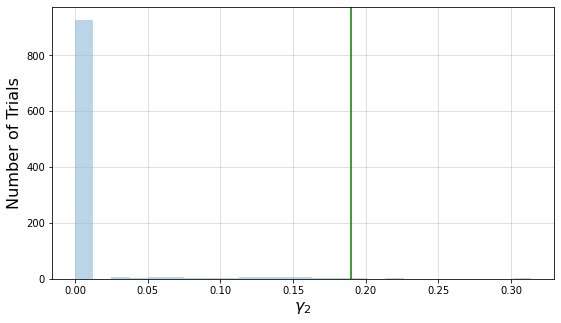

In [10]:
params= np.load("params_withpert.npy")
labels= [r"$z_0$",r"$p$","Inclination","Period",r"$\gamma_1$",r"$\gamma_2$"]
true = np.empty(6)
true[:4] = theta_0
true[4:] = ld_coef
np.save("params_withpert_true",true)
for i in range(params.shape[1]):
    plt.figure(figsize=(9,5))
    plt.hist(params[:,i],bins='scott',histtype='stepfilled',alpha=0.3)
    plt.ylabel("Number of Trials",size=16)
    plt.grid(alpha=0.5)
    plt.xlabel(labels[i],size=16)
    plt.axvline(x=true[i], label="Ground Truth", color = 'g')
    plt.savefig(labels[i])
    #plt.legend()
    plt.show()

In [ ]:
#Period estimate for non-limb darkened single planetary transit
#Eq 27 from https://iopscience.iop.org/article/10.1086/346105/fulltext/56210.text.html
def estimate_period(mass_of_star, radius_of_star, max_transit_depth, total_transit_time, ingress_time):
    
    G = 6.67e-11
    Ms = mass_of_star
    Tt = total_transit_time
    Tf = Tt - 2*ingress_time
    Rs = radius_of_star
    delta = max_transit_depth
    
    numerator = G * Ms * np.pi * (Tt**2 - Tf**2)**(3./2)
    denominator = 32*Rs**(3)*delta**(3./4)
    
    return numerator/denominator

